In [ ]:
path_notebook = '/content/drive/MyDrive/Desafio_Kaggle/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
import os
import sys
sys.path.insert(0, os.path.dirname(path_notebook))

In [ ]:
import AleTransforms as trf
import AleDatasetAnalysis as dat
import AleMLAnalysis as aml
import AleExplainers as exp
import AleLearners as lrn

In [ ]:
import importlib
importlib.reload(trf)
importlib.reload(dat)
importlib.reload(aml)
importlib.reload(exp)
importlib.reload(lrn)

<module 'AleLearners' from '/content/drive/MyDrive/Desafio_Kaggle/AleLearners.py'>

In [ ]:
import tensorflow as tf
from IPython.display import Image
from IPython.display import clear_output

import pandas as pd
import numpy as np
import random
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

import itertools

import gc

# Dataset

In [ ]:
df = pd.read_csv('https://datahub.io/machine-learning/creditcard/r/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,'0'
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,'0'
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,'0'
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,'0'


In [ ]:
frac_teste = 0.1

lista_teste = df.index[int((1-frac_teste)*len(df)):]
mask_teste = df.index.isin(lista_teste)
mask_treino = ~mask_teste

In [ ]:
n_val = 4

corta_valores = trf.CortaIntervalosQuasiUniforme(df.loc[mask_treino, 'Time'].values, num_div = 4)
valores_disc = corta_valores.aplica_discretizacao(df.loc[mask_treino, 'Time'].values)

masks_trainval = []
for i in range(0, n_val):
  mask_val = mask_treino.copy()
  mask_val[mask_treino] = valores_disc == i
  mask_train = mask_treino.copy()
  mask_train[mask_treino] = valores_disc != i
  masks_trainval.append((mask_train, mask_val))

# Construção da Rede

In [ ]:
from itertools import combinations_with_replacement

class ConicSectionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units

        super(ConicSectionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        #initializer = tf.keras.initializers.Constant(1/input_dim)
        initializer = tf.keras.initializers.GlorotUniform()

        input_dim = input_shape[-1]

        n = int(input_dim*(1 + input_dim)/2)
        self.lista_termos_2 = list(combinations_with_replacement(np.arange(input_dim), 2))

        self.kernel_0 = self.add_weight(name = 'kernel_0', shape = (1, self.units), initializer = 'normal', 
                                        trainable = True) 

        self.kernel_1 = self.add_weight(name = 'kernel_1', shape = (input_dim, self.units), initializer = 'normal', 
                                        trainable = True) 
            
        self.kernel_2 = self.add_weight(name = 'kernel_2', shape = (n, self.units), initializer = 'normal', 
                                        trainable = True) 

        super(ConicSectionLayer, self).build(input_shape)

    def call(self, x):
        x_2 = tf.transpose(tf.convert_to_tensor([x[:, v[0]]*x[:, v[1]] for v in self.lista_termos_2]))
        return self.kernel_0 + tf.keras.backend.dot(x, self.kernel_1) + tf.keras.backend.dot(x_2, self.kernel_2)

    def compute_output_shape(self, input_shape):
        return (input_shape, self.units)

In [ ]:
def cria_rede_encoder(camada_entrada, latent_dim, k):
    lista_neuronios = [32, 16]
    lista_camadas = [camada_entrada]
    for i in range(0, len(lista_neuronios)):
        n = lista_neuronios[i]
        lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'e_c{str(i)}_{str(k)}')(lista_camadas[-1]))
    camada_saida = tf.keras.layers.Dense(latent_dim, activation = 'sigmoid', name = f'el_{str(k)}')(lista_camadas[-1])
    return camada_saida

def cria_rede_clusterizador(encoder, n_clusters, k):
    lista_neuronios = [] #[8, 8]
    lista_camadas = [encoder]
    lista_camadas.append(ConicSectionLayer(8, name = f'cl_conic_{str(k)}')(lista_camadas[-1]))
    for i in range(0, len(lista_neuronios)):
        n = lista_neuronios[i]
        lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'cl_c{str(i)}_{str(k)}')(lista_camadas[-1]))
    camada_saida = tf.keras.layers.Dense(n_clusters, activation = 'softmax', name = f'cl_{str(k)}')(lista_camadas[-1])
    return camada_saida

#Pode receber como entrada o encoder ou o clusterizador
def cria_rede_decoder(encoder, dim_saida, k):
    lista_neuronios = [16, 32]
    lista_camadas = [encoder]
    for i in range(0, len(lista_neuronios)):
        n = lista_neuronios[i]
        lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'd_c{str(i)}_{str(k)}')(lista_camadas[-1]))
    camada_saida = tf.keras.layers.Dense(dim_saida, activation = 'linear', name = f'saida_{str(k)}')(lista_camadas[-1])
    return camada_saida

In [ ]:
alvo = 'Class'
coluna_temporal = 'Time'

features = [f for f in df.columns if f != alvo and f != coluna_temporal]
features = np.array(features)

In [ ]:
medias = np.mean(df.loc[mask_treino, features].values, axis = 0)
desvios = np.std(df.loc[mask_treino, features].values, axis = 0)

fil_desv = desvios > 0

def norm(X, medias, desvios):
    X_n = (X - medias)/desvios
    return np.nan_to_num(X_n, nan = 0.0)

In [ ]:
N = len(masks_trainval)
n_features = len(features[fil_desv])
latent_dim = 2
n_clusters = 8

In [ ]:
####################################

camada_entrada_encoder = tf.keras.layers.Input(n_features, name = 'entrada_e')
lista_encoders = []
for i in range(N):
    lista_encoders.append(cria_rede_encoder(camada_entrada_encoder, latent_dim, i))

#Representação Latente
encoded = tf.keras.layers.Average(name = 'espaco_latente')(lista_encoders)

encoder = tf.keras.models.Model(inputs = camada_entrada_encoder, outputs = encoded, name = 'encoder')

####################################

camada_entrada_cluterizador = tf.keras.layers.Input(shape = latent_dim, name = 'entrada_cl')
lista_clusterizadores = []
for i in range(N):
    lista_clusterizadores.append(cria_rede_clusterizador(camada_entrada_cluterizador, n_clusters, i))

clusterized = tf.keras.layers.Average(name = 'clusterizador')(lista_clusterizadores)

clusterizador = tf.keras.models.Model(inputs = camada_entrada_cluterizador, outputs = clusterized, name = 'clusterizador')

####################################

camada_entrada_decoder = tf.keras.layers.Input(shape = n_clusters, name = 'entrada_d')
lista_decoders = []
for i in range(N):
    lista_decoders.append(cria_rede_decoder(camada_entrada_decoder, n_features, i))

decoded = tf.keras.layers.Average(name = 'saida')(lista_decoders)

decoder = tf.keras.models.Model(inputs = camada_entrada_decoder, outputs = decoded, name = 'decoder')

####################################

camada_entrada = tf.keras.layers.Input(n_features, name = 'entrada')
encoded = encoder(camada_entrada)
clusterized = clusterizador(encoded)
decoded = decoder(clusterized)
autoencoder = tf.keras.models.Model(inputs = camada_entrada, outputs = decoded, name = 'autoencoder')

pesos_iniciais = autoencoder.get_weights()

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 6088      
_________________________________________________________________
clusterizador (Functional)   (None, 8)                 480       
_________________________________________________________________
decoder (Functional)         (None, 29)                6580      
Total params: 13,148
Trainable params: 13,148
Non-trainable params: 0
_________________________________________________________________


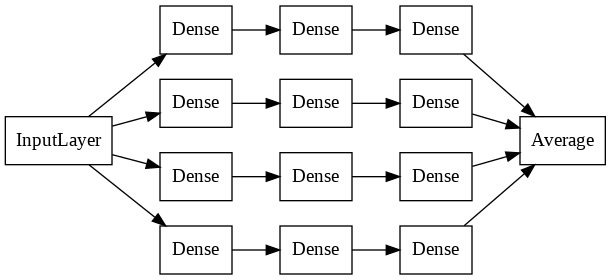

In [ ]:
encoder_dot = tf.keras.utils.model_to_dot(
    encoder,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(encoder_dot.create_png()))

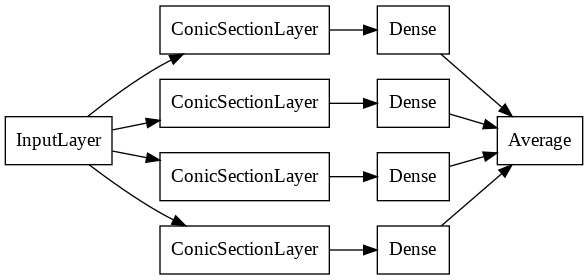

In [ ]:
clusterizador_dot = tf.keras.utils.model_to_dot(
    clusterizador,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(clusterizador_dot.create_png()))

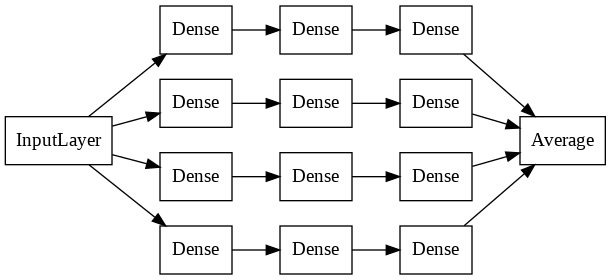

In [ ]:
decoder_dot = tf.keras.utils.model_to_dot(
    decoder,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(decoder_dot.create_png()))

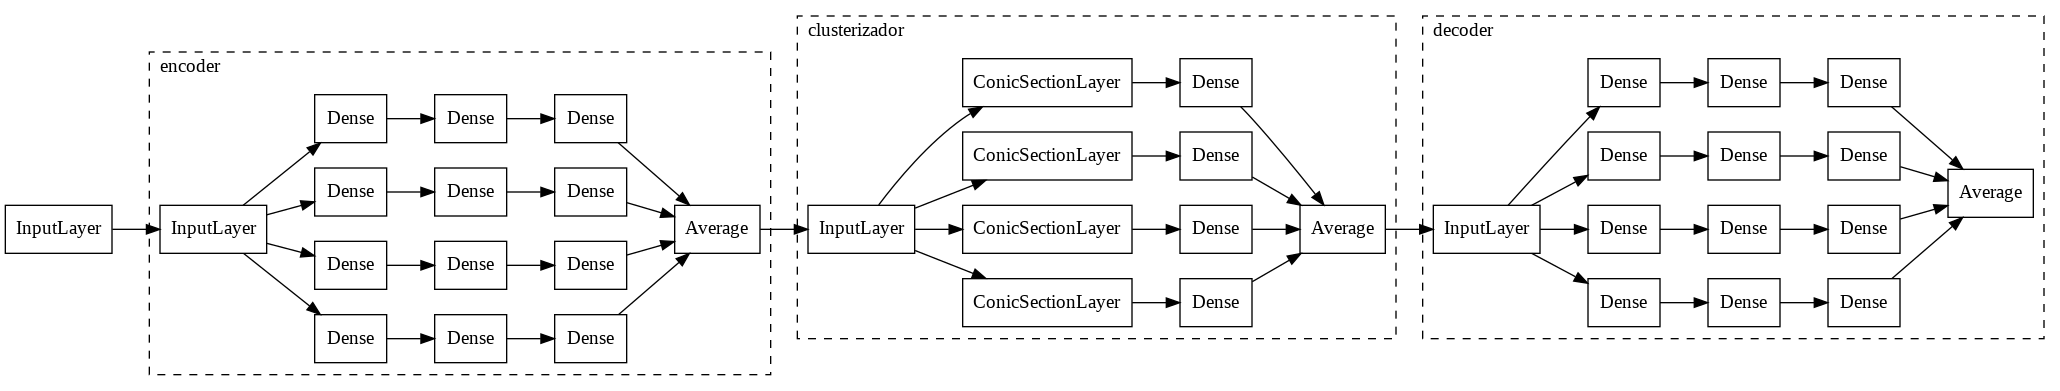

In [ ]:
autoencoder_dot = tf.keras.utils.model_to_dot(
    autoencoder,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = True,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(autoencoder_dot.create_png()))

# Treinamento da Rede

In [ ]:
def reseta_todas_camadas_treinaveis(encoder, clusterizador, decoder):
    for camada in encoder.layers:
        camada.trainable = True
    for camada in clusterizador.layers:
        camada.trainable = True
    for camada in decoder.layers:
        camada.trainable = True

def altera_camadas_treinaveis(encoder, clusterizador, decoder, k):
    for camada in encoder.layers:
        if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
            camada.trainable = True
        else:
            camada.trainable = False
    for camada in clusterizador.layers:
        if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
            camada.trainable = True
        else:
            camada.trainable = False
    for camada in decoder.layers:
        if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
            camada.trainable = True
        else:
            camada.trainable = False

In [ ]:
def plot_curva_vies_variancia(curvas_vies_variancia, lista_loss_ref, curvas_vies_variancia_media, figsize = [6, 4]):
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        for j in range(0, len(curvas_vies_variancia)):
            print(f'Conjunto {str(j)}:')
            fig, ax = plt.subplots(1, 1, figsize = figsize)
            epocas = np.arange(1, len(curvas_vies_variancia[j][0]) + 1)
            loss_train = 1 - curvas_vies_variancia[j][0]/lista_loss_ref[j][0]
            loss_val = 1 - curvas_vies_variancia[j][1]/lista_loss_ref[j][1]
            ax.plot(epocas, loss_train, color = paleta_cores[0], label = 'Treino')
            ax.plot(epocas, loss_val, color = paleta_cores[1], label = 'Validacao')
            ax.set_xlabel('Época')
            ax.set_ylabel('Loss Norm.')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()
        print('-----')
        print('Curva Média:')
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        epocas = np.arange(1, len(curvas_vies_variancia_media[0]) + 1)
        loss_train = curvas_vies_variancia_media[0]
        loss_val = curvas_vies_variancia_media[1]
        ax.plot(epocas, loss_train, color = paleta_cores[0], label = 'Treino')
        ax.plot(epocas, loss_val, color = paleta_cores[1], label = 'Validacao')
        ax.set_xlabel('Época')
        ax.set_ylabel('Loss Norm.')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
func_loss = tf.keras.losses.MeanSquaredError()
autoencoder.compile(loss = func_loss, optimizer = opt)

In [ ]:
n_loops = 10
epocas_por_loop = 2
n_batchs = 32

reseta_todas_camadas_treinaveis(encoder, clusterizador, decoder)
autoencoder.set_weights(pesos_iniciais)

callback = tf.keras.callbacks.ModelCheckpoint(
                                              'pesos_callback.h5', #hdf5
                                              monitor = 'val_loss',
                                              verbose = False,
                                              save_best_only = True,
                                              save_weights_only = True,
                                              mode = 'min',
                                              save_freq = 'epoch',
                                              )

curvas_vies_variancia = [[[], []] for v in masks_trainval]
curvas_vies_variancia_media = [[], []]
lista_loss_ref = []

for i in range(0, n_loops):
    for j in range(0, len(masks_trainval)):
        tupla = masks_trainval[j]
        x_train = norm(df.loc[tupla[0], features[fil_desv]].values, medias[fil_desv], desvios[fil_desv])
        x_val = norm(df.loc[tupla[1], features[fil_desv]].values, medias[fil_desv], desvios[fil_desv])

        if(i == 0):
            lista_loss_ref.append((func_loss(x_train, np.zeros(shape = x_train.shape)).numpy(), 
                                   func_loss(x_val, np.zeros(shape = x_val.shape)).numpy()))

        altera_camadas_treinaveis(encoder, clusterizador, decoder, j)

        H = autoencoder.fit(x_train, x_train,
                            validation_data = (x_val, x_val),
                            epochs = epocas_por_loop,
                            batch_size = math.ceil(np.sum(tupla[0])/n_batchs), 
                            callbacks = callback,
                            verbose = False)
    
        reseta_todas_camadas_treinaveis(encoder, clusterizador, decoder)

        argmin = np.argmin(H.history['val_loss'])
        curvas_vies_variancia[j][0].extend(H.history['loss'][:argmin+1])
        curvas_vies_variancia[j][1].extend(H.history['val_loss'][:argmin+1])
        autoencoder.load_weights('pesos_callback.h5')

        del x_train, x_val
        gc.collect()

        clear_output(wait = True)
        print(f'-Loop {str(i)}')
        if(i > 0):
            loss_train_acum = 0
            loss_val_acum = 0
            for k in range(0, len(masks_trainval)):
                loss_norm_train = 1 - curvas_vies_variancia[k][0][-1]/lista_loss_ref[k][0]
                loss_norm_val = 1 - curvas_vies_variancia[k][1][-1]/lista_loss_ref[k][1]
                loss_train_acum = loss_train_acum + loss_norm_train
                loss_val_acum = loss_val_acum + loss_norm_val

                loss_norm_train = round(loss_norm_train, 3)
                loss_norm_val = round(loss_norm_val, 3)
                if(k == j):
                    print(f'Conjunto {str(k)}: {str(loss_norm_train)} / {str(loss_norm_val)} <-')
                else:
                    print(f'Conjunto {str(k)}: {str(loss_norm_train)} / {str(loss_norm_val)}')
            
            loss_train_acum = loss_train_acum/len(masks_trainval)
            loss_val_acum = loss_val_acum/len(masks_trainval)
            curvas_vies_variancia_media[0].append(loss_train_acum)
            curvas_vies_variancia_media[1].append(loss_val_acum)

            loss_train_acum = round(loss_train_acum, 3)
            loss_val_acum = round(loss_val_acum, 3)
            print('-----')
            print(f'Média: {str(loss_train_acum)} / {str(loss_val_acum)}')
        else:
            loss_norm_train = round(1 - curvas_vies_variancia[j][0][-1]/lista_loss_ref[j][0], 3)
            loss_norm_val = round(1 - curvas_vies_variancia[j][1][-1]/lista_loss_ref[j][1], 3)
            print(f'Conjunto {str(j)}: {str(loss_norm_train)} / {str(loss_norm_val)}')

-Loop 9
Conjunto 0: 0.194 / 0.209
Conjunto 1: 0.207 / 0.162
Conjunto 2: 0.2 / 0.207
Conjunto 3: 0.208 / 0.165 <-
-----
Média: 0.202 / 0.186


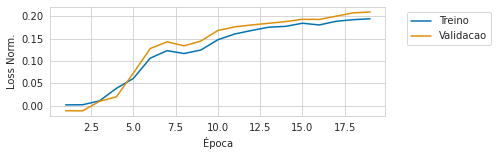

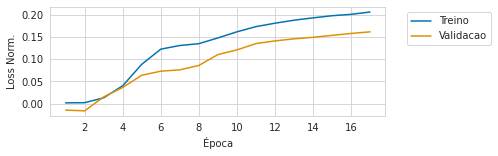

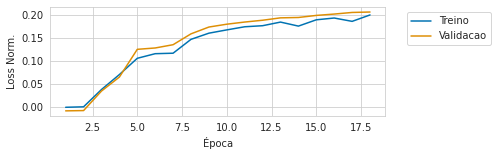

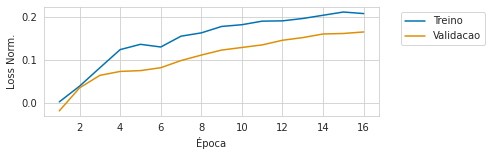

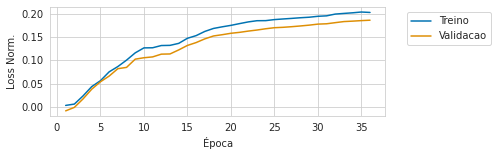

In [ ]:
plot_curva_vies_variancia(curvas_vies_variancia, lista_loss_ref, curvas_vies_variancia_media, figsize = [6, 2])

# Avaliação

In [ ]:
def calcula_loss_norm(func_loss, autoencoder, X, medias, desvios):
    X_norm = norm(X, medias, desvios)
    loss_ref = func_loss(X_norm, np.zeros(shape = X.shape)).numpy()
    pred = autoencoder.predict(X_norm)
    loss = func_loss(X_norm, pred).numpy()
    return 1 - loss/loss_ref

In [ ]:
dict_loss_norm = {
          'Treino': calcula_loss_norm(func_loss, autoencoder, df.loc[mask_treino, features].values, medias, desvios),
          'Teste': calcula_loss_norm(func_loss, autoencoder, df.loc[mask_teste, features].values, medias, desvios)
          }

In [ ]:
display(pd.DataFrame(pd.Series(dict_loss_norm)))

,0
Treino,0.198937
Teste,0.195826


In [ ]:
def plot_loss_norm_temporal(df_loss_norm_tempo, corta_tempo, figsize = [6, 4]):
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        i = 0
        for conjunto in ['Treino', 'Teste']:
            df_aux = df_loss_norm_tempo.loc[df_loss_norm_tempo.index.get_level_values(0) == conjunto, :]
            tempo_disc = df_aux.index.get_level_values(1)
            map_tempo = dict(zip(np.arange(corta_tempo.strings_intervalos_discretizacao().size), corta_tempo.strings_intervalos_discretizacao()))
            tempo = [map_tempo[v] for v in tempo_disc]
            loss_norm = df_aux['Loss_Norm']
            ax.plot(tempo, loss_norm, 'o-', color = paleta_cores[i], label = conjunto)
            i = i + 1
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Loss Norm.')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_ylim([0, 1])
        plt.xticks(rotation = 90)
        plt.show()

In [ ]:
df_aval = df.loc[:, features].copy()
corta_tempo = trf.CortaIntervalosQuasiUniforme(df[coluna_temporal].values, num_div = 50)
df_aval['Tempo_Disc'] = corta_tempo.aplica_discretizacao(df[coluna_temporal].values)
df_aval['Conjunto'] = np.nan
df_aval.loc[mask_treino, 'Conjunto'] = 'Treino'
df_aval.loc[mask_teste, 'Conjunto'] = 'Teste'
df_loss_norm_tempo = pd.DataFrame(df_aval.groupby(['Conjunto', 'Tempo_Disc']).apply(lambda x: calcula_loss_norm(func_loss, autoencoder, x.loc[:, features].values, medias, desvios)), columns = ['Loss_Norm'])

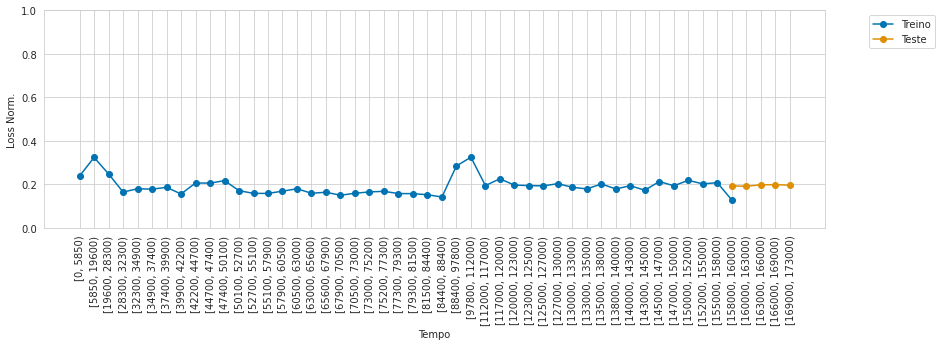

In [ ]:
plot_loss_norm_temporal(df_loss_norm_tempo, corta_tempo, figsize = [14, 4])

# Espaço Latente

In [ ]:
def plot_espaco_latente(dict_encoded, frac = 1.0, alpha = 1.0, size = 1.0, seed = 42, figsize = [6, 6]):
    paleta_cores = sns.color_palette("colorblind")
    A = mpl.rcParams['lines.markersize'] ** 2
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        ax.set_xlabel('Feature 0')
        ax.set_ylabel('Feature 1')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(False)
        ax.set_aspect('equal', adjustable = 'box')
        i = 0
        hlds = []
        for chave in dict_encoded.keys():
            x = dict_encoded[chave][:, 0]
            y = dict_encoded[chave][:, 1]
            random.seed(seed)
            indices = random.sample(list(range(0, x.size)), int(frac*x.size))
            ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = paleta_cores[i])
            hlds.append(mpl.patches.Patch(color = paleta_cores[i], label = chave))
            i = i + 1
        ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

In [ ]:
encoded_treino = encoder.predict(norm(df.loc[mask_treino, features].values, medias, desvios))
encoded_teste = encoder.predict(norm(df.loc[mask_teste, features].values, medias, desvios))

In [ ]:
dict_encoded = {
                'Treino': encoded_treino,
                'Teste': encoded_teste
                }

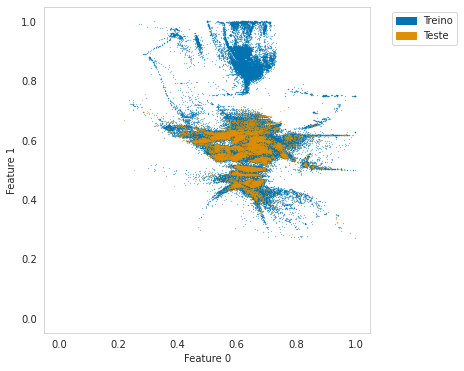

In [ ]:
plot_espaco_latente(dict_encoded, frac = 1.0, alpha = 1.0, size = 0.001, seed = 42, figsize = [6, 6])

# Clusterização

In [ ]:
def predict_cluster(clusters_prob, probs_corte, probs_max, grau_confianca = 0):
    if(grau_confianca == 0):
        clusters = np.argmax((clusters_prob - probs_corte)/(probs_max - probs_corte), axis = 1)
    else:
        clusters = -1*np.ones(clusters_prob.shape[0])
        prob_norm = np.max((clusters_prob - probs_corte)/(probs_max - probs_corte), axis = 1)
        flag_confianca = prob_norm >= grau_confianca
        clusters[flag_confianca] = np.argmax((clusters_prob[flag_confianca] - probs_corte)/(probs_max - probs_corte), axis = 1)
    return clusters.astype(int)

def predict_confianca_cluster(clusters_prob, probs_corte, probs_max):
    prob_norm = np.max((clusters_prob - probs_corte)/(probs_max - probs_corte), axis = 1)
    return np.array([min(1, p) for p in prob_norm])

In [ ]:
def plot_clusters(encoded, clusters, frac = 1, alpha = 1.0, size = 1.0, seed = 42, figsize = [6, 6]):
    paleta_cores = sns.color_palette("colorblind")
    A = mpl.rcParams['lines.markersize'] ** 2
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        ax.set_xlabel('Feature 0')
        ax.set_ylabel('Feature 1')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(False)
        ax.set_aspect('equal', adjustable = 'box')
        hlds = []
        for cluster in np.unique(clusters):
            if(cluster == -1):
                x = encoded[clusters == cluster, 0]
                y = encoded[clusters == cluster, 1]
                random.seed(seed)
                indices = random.sample(list(range(0, x.size)), int(frac*x.size))
                ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = 'black')
                hlds.append(mpl.patches.Patch(color = 'black', label = f'Cluster {str(cluster)}'))
            else:
                x = encoded[clusters == cluster, 0]
                y = encoded[clusters == cluster, 1]
                random.seed(seed)
                indices = random.sample(list(range(0, x.size)), int(frac*x.size))
                ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = paleta_cores[cluster])
                hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
        ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

def plot_contorno_clusters(clusterizador, probs_corte, probs_max, plot_confianca = True, N = 100, figsize = [6, 6]):
    pontos = (np.arange(0, N) + 0.5)/N
    encoded_grid = np.array(list(itertools.product(pontos, pontos)))
    clusters_prob = clusterizador.predict(encoded_grid)
    clusters = predict_cluster(clusters_prob, probs_corte, probs_max)
    confianca = predict_confianca_cluster(clusters_prob, probs_corte, probs_max)

    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        ax.set_xlabel('Feature 0')
        ax.set_ylabel('Feature 1')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(False)
        ax.set_aspect('equal', adjustable = 'box')
        L = 1/N
        hlds = []
        for cluster in np.unique(clusters):
            if(cluster == -1):
                x = encoded_grid[clusters == cluster, 0]
                y = encoded_grid[clusters == cluster, 1]
                for x, y in zip(x, y):
                    ax.add_artist(Rectangle(xy = (x, y), color = 'white', width = L, height = L, zorder = 0))
                hlds.append(mpl.patches.Patch(color = 'white', label = f'Cluster {str(cluster)}'))
            else:
                x = encoded_grid[clusters == cluster, 0]
                y = encoded_grid[clusters == cluster, 1]
                if(plot_confianca):
                    confianca = 0.9*confianca + 0.1
                    cores = [paleta_cores[cluster] + (a,) for a in confianca[clusters == cluster]]
                else:
                    cores = [paleta_cores[cluster] for a in confianca[clusters == cluster]]
                for x, y, c in zip(x, y, cores):
                    ax.add_artist(Rectangle(xy = (x, y), color = c, linewidth = 0, width = L, height = L, zorder = 0))
                hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
        ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

def plot_contorno_clusters_e_pontos(encoded, clusterizador, probs_corte, probs_max, plot_confianca = True, N = 100, 
                                    alpha = 1.0, size = 1.0, figsize = [6, 6]):
    pontos = (np.arange(0, N) + 0.5)/N
    encoded_grid = np.array(list(itertools.product(pontos, pontos)))
    clusters_prob = clusterizador.predict(encoded_grid)
    clusters = predict_cluster(clusters_prob, probs_corte, probs_max)
    confianca = predict_confianca_cluster(clusters_prob, probs_corte, probs_max)

    paleta_cores = sns.color_palette("colorblind")
    A = mpl.rcParams['lines.markersize'] ** 2
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        ax.set_xlabel('Feature 0')
        ax.set_ylabel('Feature 1')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(False)
        ax.set_aspect('equal', adjustable = 'box')
        L = 1/N
        hlds = []      
        for cluster in np.unique(clusters):
            if(cluster == -1):
                x = encoded_grid[clusters == cluster, 0]
                y = encoded_grid[clusters == cluster, 1]
                for x, y in zip(x, y):
                    ax.add_artist(Rectangle(xy = (x, y), color = 'white', width = L, height = L, zorder = 0))
                hlds.append(mpl.patches.Patch(color = 'white', label = f'Cluster {str(cluster)}'))
            else:
                x = encoded_grid[clusters == cluster, 0]
                y = encoded_grid[clusters == cluster, 1]
                if(plot_confianca):
                    confianca = 0.9*confianca + 0.1
                    cores = [paleta_cores[cluster] + (a,) for a in confianca[clusters == cluster]]
                else:
                    cores = [paleta_cores[cluster] for a in confianca[clusters == cluster]]
                for x, y, c in zip(x, y, cores):
                    ax.add_artist(Rectangle(xy = (x, y), color = c, linewidth = 0, width = L, height = L, zorder = 0))
                hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
        ax.scatter(encoded[:, 0], encoded[:, 1], color = 'black', alpha = alpha, s = size*A)
        ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

In [ ]:
clusters_prob_treino = clusterizador.predict(encoded_treino)
clusters_prob_teste = clusterizador.predict(encoded_teste)

In [ ]:
probs_corte = np.mean(clusters_prob_treino, axis = 0)
probs_max = np.max(clusters_prob_treino, axis = 0)
print(probs_corte)
print(probs_max)

[0.1146507  0.09208129 0.05623413 0.41981128 0.10250893 0.13172466
 0.0468156  0.03621585]
[0.73493403 0.4952702  0.08718534 0.9709393  0.1603322  0.557221
 0.06748966 0.0496774 ]


In [ ]:
clusters_treino = predict_cluster(clusters_prob_treino, probs_corte, probs_max, grau_confianca = 0.0)
clusters_teste = predict_cluster(clusters_prob_teste, probs_corte, probs_max, grau_confianca = 0.0)

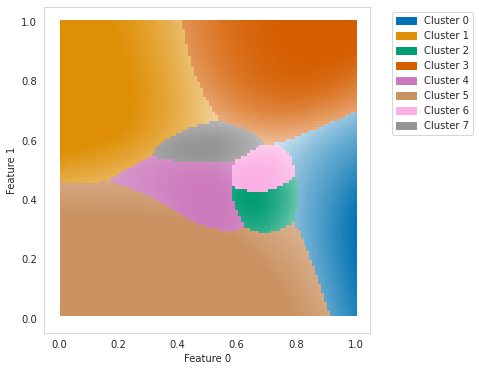

In [ ]:
plot_contorno_clusters(clusterizador, probs_corte, probs_max, figsize = [6, 6])
#plot_contorno_clusters(clusterizador, probs_corte, probs_max, plot_confianca = False, figsize = [6, 6]) 

Treino


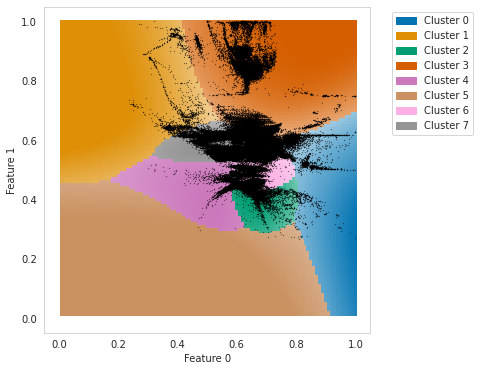

Teste


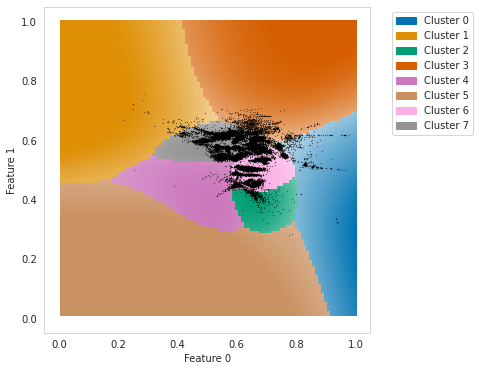

In [ ]:
print('Treino')
plot_contorno_clusters_e_pontos(encoded_treino, clusterizador, probs_corte, probs_max, alpha = 1.0, size = 0.001, figsize = [6, 6])
print('Teste')
plot_contorno_clusters_e_pontos(encoded_teste, clusterizador, probs_corte, probs_max, alpha = 1.0, size = 0.001, figsize = [6, 6])

Treino


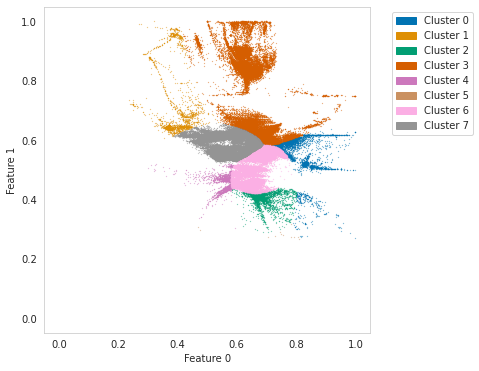

Teste


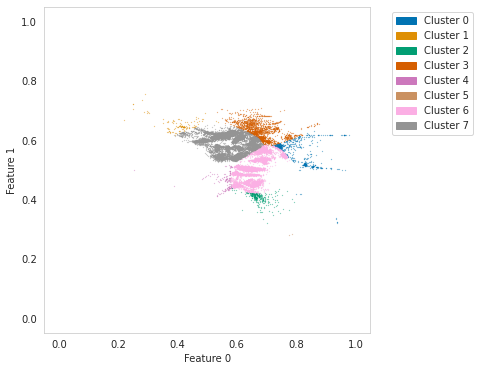

In [ ]:
print('Treino')
plot_clusters(encoded_treino, clusters_treino, frac = 1.0, alpha = 1.0, size = 0.001, seed = 42, figsize = [6, 6])
print('Teste')
plot_clusters(encoded_teste, clusters_teste, frac = 1.0, alpha = 1.0, size = 0.001, seed = 42, figsize = [6, 6])

# Detecção de Anomalias

In [ ]:
def predict_grau_anomalia(X, pred, mse, medias,desvios):
    X_norm = norm(X, medias, desvios)
    mse_x = np.mean(np.power(X_norm - pred, 2), axis = 1)
    return mse_x

In [ ]:
def plot_anomalias(encoded, grau_anomalia, corte_anomalia = 0, alpha = 1.0, seed = 42, figsize = [6, 6]):
    paleta_cores = sns.color_palette("colorblind")
    A = mpl.rcParams['lines.markersize'] ** 2
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        ax.set_xlabel('Feature 0')
        ax.set_ylabel('Feature 1')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(False)
        ax.set_aspect('equal', adjustable = 'box')

        sizes = np.array([int((1 + g)*A) for g in grau_anomalia])/np.max(grau_anomalia)
        anomalias = grau_anomalia > corte_anomalia

        ax.scatter(encoded[~anomalias, 0], encoded[~anomalias, 1], s = sizes[~anomalias], color = paleta_cores[0], alpha = alpha)
        #ax.scatter(encoded[~anomalias, 0], encoded[~anomalias, 1], color = paleta_cores[0], alpha = alpha)

        ax.scatter(encoded[anomalias, 0], encoded[anomalias, 1], s = sizes[anomalias], color = paleta_cores[1], alpha = alpha)
        #ax.scatter(encoded[anomalias, 0], encoded[anomalias, 1], color = paleta_cores[1], alpha = alpha)

        hlds = []
        hlds.append(mpl.patches.Patch(color = paleta_cores[0], label = 'Normais'))
        hlds.append(mpl.patches.Patch(color = paleta_cores[1], label = 'Anomalias'))
        ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

In [ ]:
predict_treino = autoencoder.predict(norm(df.loc[mask_treino, features].values, medias, desvios))
predict_teste = autoencoder.predict(norm(df.loc[mask_teste, features].values, medias, desvios))

In [ ]:
grau_an_treino = predict_grau_anomalia(df.loc[mask_treino, features].values, predict_treino, mse, medias, desvios)
grau_an_teste = predict_grau_anomalia(df.loc[mask_teste, features].values, predict_teste, mse, medias, desvios)

In [ ]:
#'0'    0.998166
#'1'    0.001834

frac_an = 0.01
corte_anomalia = np.sort(grau_an_treino)[-int(frac_an*grau_an_treino.size)]
print(corte_anomalia)

2.644993896689566


Treino


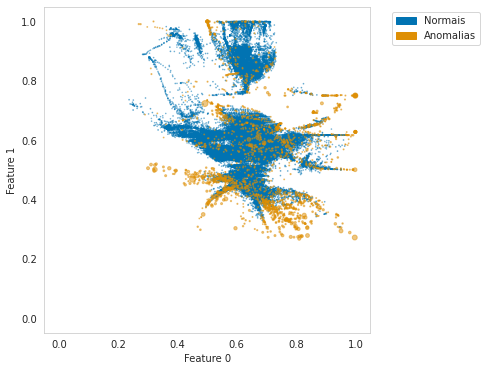

Teste


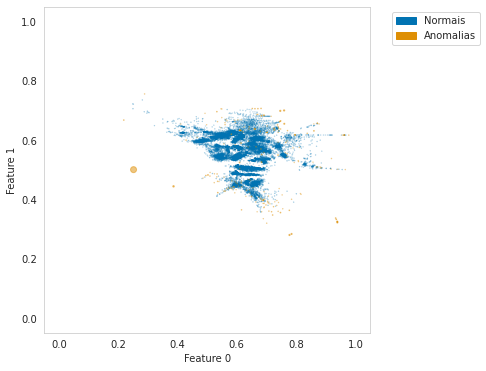

In [ ]:
print('Treino')
plot_anomalias(encoded_treino, grau_an_treino, corte_anomalia = corte_anomalia, alpha = 0.5, seed = 42, figsize = [6, 6])
print('Teste')
plot_anomalias(encoded_teste, grau_an_teste, corte_anomalia = corte_anomalia, alpha = 0.5, seed = 42, figsize = [6, 6])

# Análises Clusters

In [ ]:
def plot_bivariadas_clusters(df, frac = 1, alpha = 0.1, size = 1.0, seed = 42, figsize = [6, 4]):
  paleta_cores = sns.color_palette("colorblind")
  A = mpl.rcParams['lines.markersize'] ** 2
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      hlds = []
      for cluster in df.index:
        if(cluster == -1):
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = 'black')
          hlds.append(mpl.patches.Patch(color = 'black', label = f'Cluster {str(cluster)}'))
        else:
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = paleta_cores[cluster])
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
      ax.set_xlabel(df.columns[0])
      ax.set_ylabel(df.columns[1])
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [ ]:
print('Treino')
df_aux = df.loc[mask_treino, features].copy()
df_aux['Cluster'] = clusters_treino
display(df_aux.groupby('Cluster').mean())

print('Teste')
df_aux = df.loc[mask_teste, features].copy()
df_aux['Cluster'] = clusters_teste
display(df_aux.groupby('Cluster').mean())

Treino


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.644488,0.834039,-0.383786,0.658149,0.017560,1.153577,-1.442016,-4.216516,-0.195676,0.001178,-0.147586,0.520700,-0.140903,0.300766,0.500798,-0.100160,0.439351,0.117185,0.849392,-0.388994,0.355309,0.040386,0.103650,0.021419,-0.097333,0.191159,-0.094212,0.275967,78.116577
1,-0.473210,2.106051,-2.703113,1.803839,0.838641,-0.909485,0.293180,0.383117,-0.236566,-0.690296,1.253937,-0.545919,0.060797,-2.886259,0.508911,1.112524,2.919898,1.487692,-0.770464,0.160523,-0.203121,-0.335627,-0.018895,-0.371160,0.085793,-0.271296,0.044165,-0.058953,24.196054
2,-5.186812,-4.775896,0.235639,0.974025,2.921549,-1.755412,-1.308146,0.066627,0.266328,0.127151,-0.046613,0.330688,-0.039410,-0.017233,0.135588,0.087153,-0.121410,-0.017162,0.101885,-0.364774,-0.092603,0.129969,0.815310,-0.015417,0.105653,0.038107,0.176971,-0.300412,181.755582
3,-0.945194,0.954911,0.379962,-0.112073,-0.004515,-0.078043,0.034272,0.153373,0.637526,-0.035486,0.453385,-0.804264,0.551905,0.518033,-0.062668,0.048638,0.044501,-0.068614,-0.043340,0.087655,-0.050380,-0.238804,0.005726,0.006987,-0.078371,0.131694,-0.005167,-0.005081,37.814458
4,-3.516704,-5.088656,-2.496628,0.786062,-4.425239,2.585752,4.504445,-1.186934,-0.488404,-0.873591,-0.005723,-0.165201,0.108383,0.130697,0.030530,0.269230,0.021660,0.142901,-0.320460,1.582565,0.490015,-0.421566,-0.805854,0.118348,-0.410402,-0.050178,0.284283,-0.131537,1957.359483
5,-29.956909,-40.446895,-5.247440,10.793665,17.305550,-13.235243,-9.592076,-0.600607,3.001575,1.236130,0.899923,1.530037,2.000122,1.395025,2.331342,1.479436,0.231878,0.320292,0.523599,1.097757,0.075449,-2.086835,-3.698016,0.805142,-1.045684,-0.047691,3.815983,-1.963898,3597.977500
6,0.022476,-0.434192,0.436644,-0.115173,-0.348276,0.221605,-0.154519,0.102782,-0.710018,0.407863,-0.141254,-0.092479,-0.030782,-0.081535,-0.083161,-0.109646,0.049760,-0.002530,0.032445,0.021483,0.019897,0.094872,-0.022802,-0.009031,0.009218,-0.106733,-0.004552,0.003591,123.856179
7,0.749927,0.093306,-0.273574,0.086906,0.191129,-0.139471,0.128628,0.033979,0.378167,-0.340858,-0.022029,0.387834,-0.221223,-0.084428,0.118404,0.045778,-0.131458,-0.037770,-0.036018,-0.051539,-0.013937,0.011988,-0.014647,0.013853,0.076590,0.037772,-0.003540,0.003664,50.662134


Teste


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.768232,1.385824,-0.640290,0.567394,0.091032,1.038598,-1.237271,-3.623398,-0.419491,-0.225849,-0.399557,0.470653,-0.057441,0.399647,0.491611,-0.252753,0.592432,0.335666,1.165696,0.100698,0.315087,0.283186,0.075616,0.060716,-0.279520,0.261532,0.000097,0.235221,60.686568
1,0.066845,1.830921,-2.022439,2.817501,1.256349,-0.488983,0.500384,-0.113363,-1.018015,-0.476103,0.611348,-0.461135,-0.246793,-3.106973,-0.342846,1.385465,2.362778,1.404627,-0.891259,0.022640,-0.258921,-0.350675,0.020291,-0.486664,-0.151906,-0.176947,-0.076431,-0.024181,33.812126
2,-4.519551,-4.490344,-0.292062,0.957881,3.271739,-1.772685,-1.218797,0.257156,0.046260,-0.073865,-0.444805,0.271015,0.028590,0.109622,0.044162,-0.007256,-0.168482,0.326797,0.180842,0.110976,0.155537,0.129489,0.714739,0.050721,-0.105745,0.091148,0.308872,-0.376188,185.698947
3,-2.673382,2.359422,-1.390357,-0.906131,-0.138682,-0.348934,-0.135126,0.621837,0.641459,0.964079,-0.407288,0.483664,-0.067762,0.201888,-0.180250,0.045192,-0.080802,-0.058873,0.028728,0.316950,0.065221,-0.152205,0.101136,-0.085395,-0.078581,0.085868,-0.069736,-0.020978,19.283026
4,-2.807163,-4.076154,-3.082986,0.977623,-4.649400,2.906988,5.221337,-0.937690,-0.874368,-0.598784,-0.487426,-0.370073,0.224298,0.055040,-0.260169,0.126270,-0.149826,0.649863,-0.259691,0.744313,0.180328,0.031031,-0.219210,0.155237,-0.506388,-0.031876,0.531242,-0.356103,1770.815597
5,-25.194640,-30.306975,-2.480649,6.172756,13.793673,-9.427880,-2.430188,-1.390600,2.663563,1.354055,-0.628398,-0.380548,1.588279,-1.958521,1.400011,2.581570,-1.511738,-0.822125,3.159922,-11.533243,-4.593862,2.958676,21.443444,0.096201,5.948505,1.020069,6.783081,-4.032627,517.070000
6,0.416511,-0.491351,-0.290784,-0.227850,-0.149011,0.184093,-0.166613,0.063506,-0.720968,0.547770,-0.445304,-0.100780,0.134787,-0.066000,-0.334984,-0.151962,-0.070340,0.194424,0.004602,-0.045961,0.018991,0.152691,0.009514,-0.010245,-0.125630,-0.098889,-0.002990,-0.011533,116.102694
7,0.693566,0.312686,-0.849948,-0.141554,0.528956,-0.302897,0.324088,0.003696,0.311793,-0.370800,-0.198298,0.352949,-0.111221,-0.183678,-0.127525,0.097140,-0.113868,0.059552,0.000603,-0.080868,-0.011321,0.055318,0.038890,-0.000579,-0.164684,0.012918,0.008094,-0.000469,36.992801


In [ ]:
df_aux = df.loc[mask_treino, features].copy()
df_aux['Cluster'] = clusters_treino
df_temp = df_aux.groupby('Cluster').mean()
lista_colunas_imp = list((df_temp.std(axis = 0)/df_temp.mean(axis = 0)).abs().sort_values(ascending = False).index[:4])

Treino


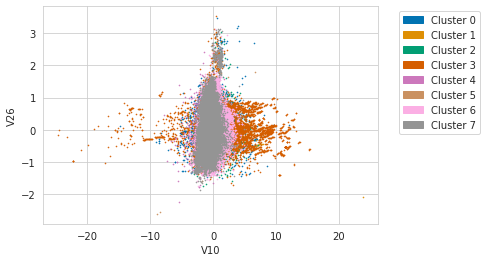

Treino


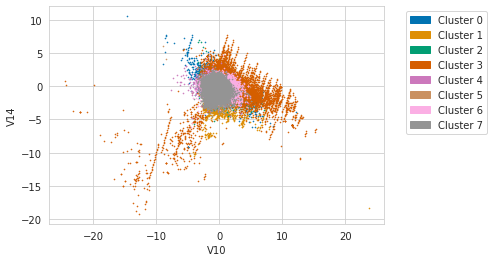

Treino


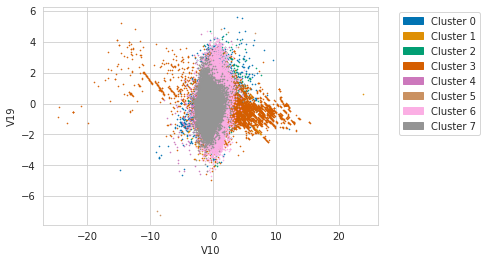

Treino


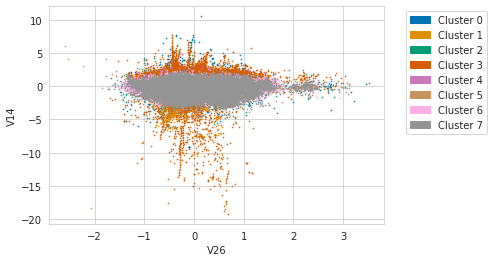

Treino


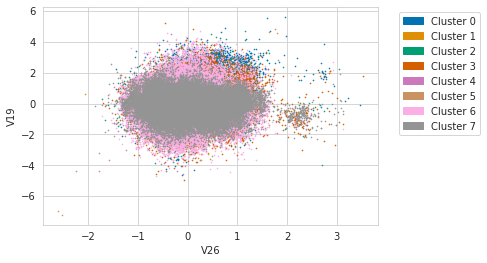

Treino


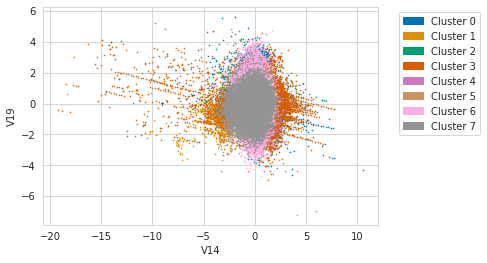

In [ ]:
df_aux = df.loc[mask_treino, lista_colunas_imp].copy()
df_aux['Cluster'] = clusters_treino

comb_columns = list(itertools.combinations(lista_colunas_imp, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Cluster').apply(lambda x: f(x, comb))
  print('Treino')
  plot_bivariadas_clusters(df_temp, frac = 1, alpha = 1, size = 0.01, seed = 42, figsize = [6, 4])

Teste


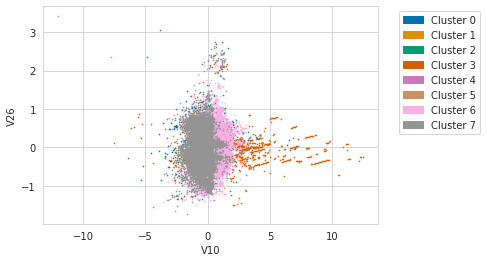

Teste


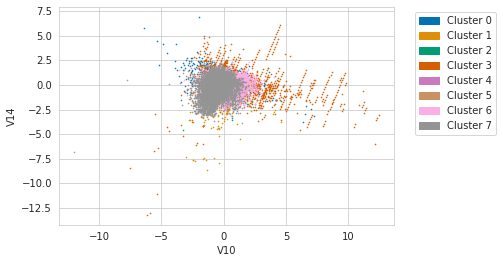

Teste


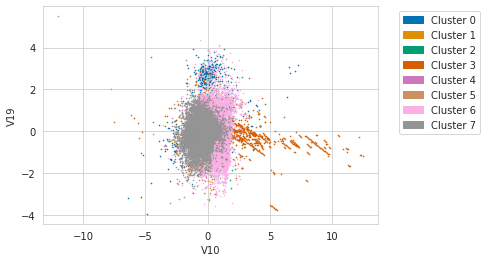

Teste


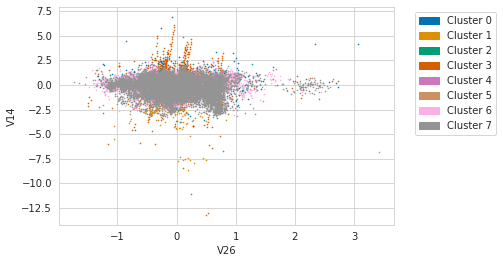

Teste


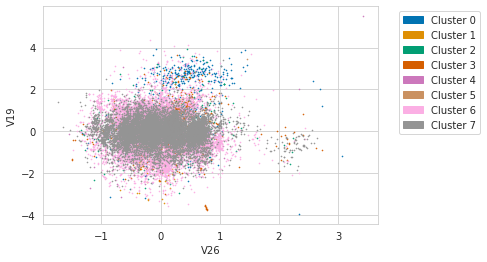

Teste


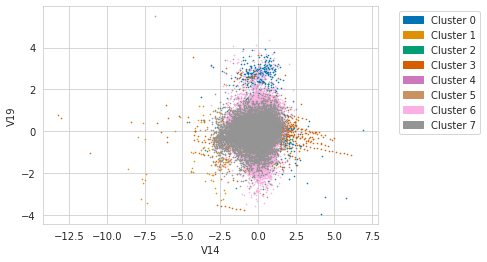

In [ ]:
df_aux = df.loc[mask_teste, lista_colunas_imp].copy()
df_aux['Cluster'] = clusters_teste

comb_columns = list(itertools.combinations(lista_colunas_imp, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Cluster').apply(lambda x: f(x, comb))
  print('Teste')
  plot_bivariadas_clusters(df_temp, frac = 1, alpha = 1, size = 0.01, seed = 42, figsize = [6, 4])

# Análises Anomalias

In [ ]:
def plot_bivariadas_anomalias(df, frac = 1, alpha = 0.1, size = 1.0, seed = 42, figsize = [6, 4]):
  paleta_cores = sns.color_palette("colorblind")
  A = mpl.rcParams['lines.markersize'] ** 2
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      hlds = []
      for cluster in df.index:
        if(cluster == -1):
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = 'black')
          hlds.append(mpl.patches.Patch(color = 'black', label = f'Anomalia {str(cluster)}'))
        else:
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = paleta_cores[cluster])
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Anomalia {str(cluster)}'))
      ax.set_xlabel(df.columns[0])
      ax.set_ylabel(df.columns[1])
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [ ]:
print('Treino')
df_aux = df.loc[mask_treino, features].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia
display(df_aux.groupby('Anomalia').mean())

print('Teste')
df_aux = df.loc[mask_teste, features].copy()
df_aux['Anomalia'] = grau_an_teste > corte_anomalia
display(df_aux.groupby('Anomalia').mean())

Treino


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Anomalia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0.049852,0.011641,0.113759,0.002396,-0.021329,0.013173,-0.004922,0.023092,-0.005851,-0.001492,0.024209,-0.016745,0.000361,0.022682,0.017074,0.000481,0.016311,-0.007456,-0.004015,0.013465,-0.001591,-0.006704,-0.000894,0.000457,0.017512,0.001767,0.001615,0.003970,84.532415
True,-7.749945,-2.958540,-3.213378,1.674854,-1.042049,0.199586,-0.846459,-2.104521,0.622584,0.176734,0.834529,-0.797713,0.310696,-0.922775,0.301435,-0.234922,-0.798548,-0.478115,0.113871,-0.952982,0.033639,-0.163199,-0.388921,0.051194,-0.065089,-0.060112,-0.219770,-0.321522,673.163158


Teste


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Anomalia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0.304166,0.176738,-0.707636,-0.182240,0.290657,-0.143720,0.121800,0.005039,-0.007612,-0.009033,-0.291278,0.220527,-0.032436,-0.116729,-0.182239,0.014115,-0.075785,0.109074,0.026204,-0.028211,0.010562,0.073839,0.045592,-0.008810,-0.149874,-0.010721,0.008380,-0.003729,65.916323
True,-6.385563,-1.694869,-2.914776,1.154048,-0.608027,0.953503,-0.113736,-2.800847,0.480794,0.831073,-0.225086,0.276506,0.133883,-0.424571,0.208792,0.370485,0.223381,0.157014,-0.061556,-0.817025,0.087683,0.149057,-0.299020,0.008094,-0.189098,0.040021,-0.383511,-0.359018,567.290046


In [ ]:
df_aux = df.loc[mask_treino, features].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia
df_temp = df_aux.groupby('Anomalia').mean()
lista_colunas_imp = list((df_temp.std(axis = 0)/df_temp.mean(axis = 0)).abs().sort_values(ascending = False).index[:4])

Treino


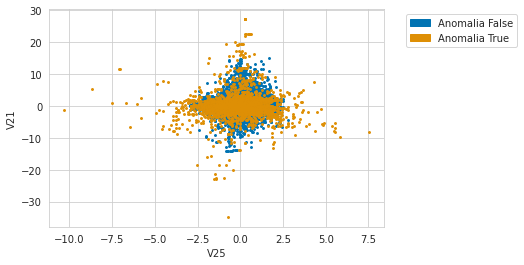

Treino


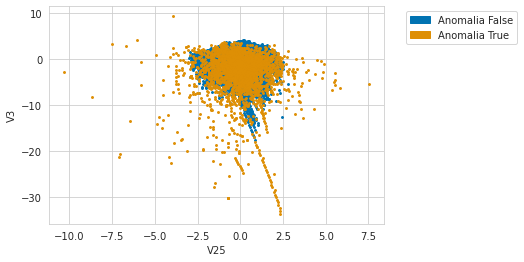

Treino


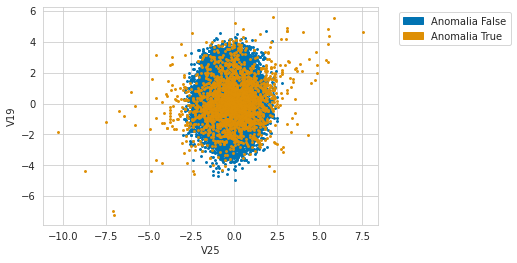

Treino


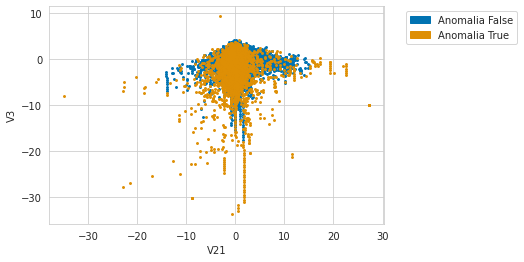

Treino


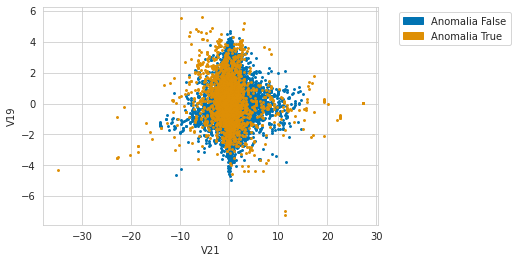

Treino


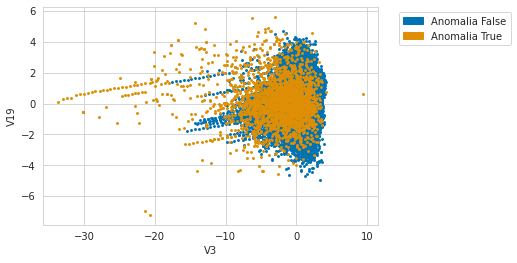

In [ ]:
df_aux = df.loc[mask_treino, lista_colunas_imp].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia

comb_columns = list(itertools.combinations(lista_colunas_imp, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Anomalia').apply(lambda x: f(x, comb))
  print('Treino')
  plot_bivariadas_anomalias(df_temp, frac = 1, alpha = 1, size = 0.1, seed = 42, figsize = [6, 4])

Teste


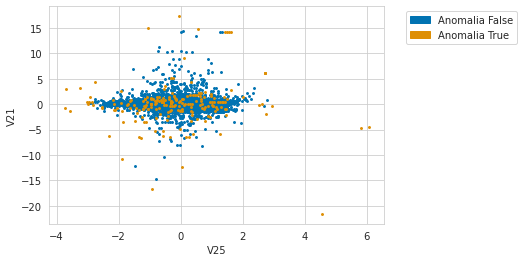

Teste


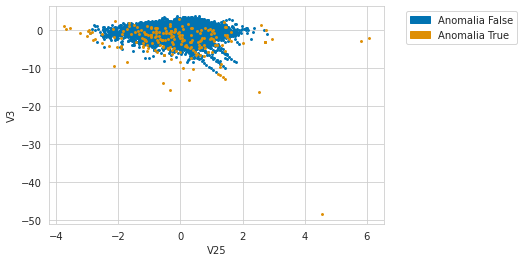

Teste


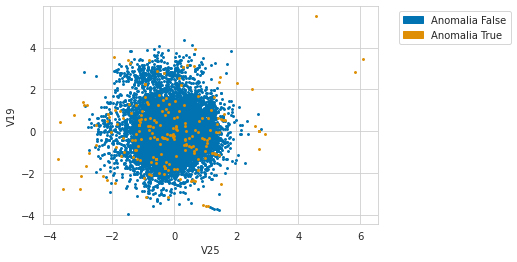

Teste


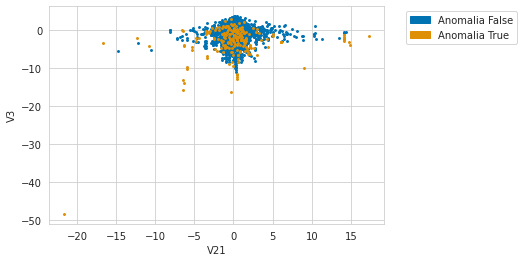

Teste


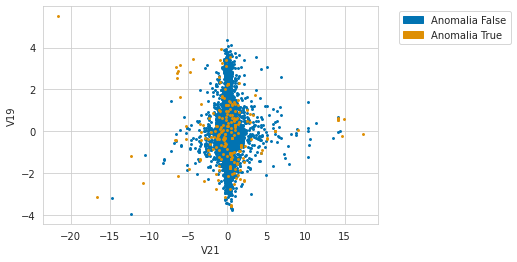

Teste


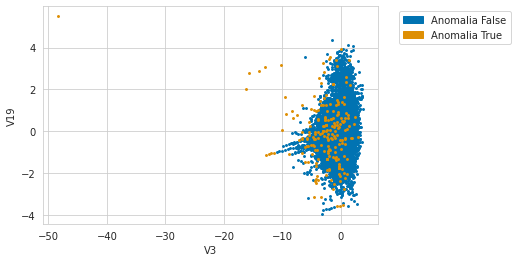

In [ ]:
df_aux = df.loc[mask_teste, lista_colunas_imp].copy()
df_aux['Anomalia'] = grau_an_teste > corte_anomalia

comb_columns = list(itertools.combinations(lista_colunas_imp, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Anomalia').apply(lambda x: f(x, comb))
  print('Teste')
  plot_bivariadas_anomalias(df_temp, frac = 1, alpha = 1, size = 0.1, seed = 42, figsize = [6, 4])

### Análise Clusters - Alvo Oculto

In [ ]:
def g(x):
  y = (x[alvo].value_counts()/x.shape[0])
  d = {}
  for ind in y.index:
    d[ind] = y[ind]
  return pd.DataFrame(pd.Series(d, name = '')).transpose()

In [ ]:
print('Treino')
df_aux = df.loc[mask_treino, [alvo]].copy()
df_aux['Cluster'] = clusters_treino
df_res = pd.DataFrame(df_aux.groupby('Cluster').apply(lambda x: g(x)))
display(df_res)

print('Teste')
df_aux = df.loc[mask_teste, [alvo]].copy()
df_aux['Cluster'] = clusters_teste
df_res = pd.DataFrame(df_aux.groupby('Cluster').apply(lambda x: g(x)))
display(df_res)

Treino


,,'0','1'
Cluster,,,
0,,0.996930,0.003070
1,,0.983065,0.016935
2,,0.997657,0.002343
3,,0.992536,0.007464
4,,0.997651,0.002349
5,,1.000000,NaN
6,,0.999789,0.000211
7,,0.999762,0.000238


Teste


,,'0','1'
Cluster,,,
0,,0.998350,0.001650
1,,1.000000,NaN
2,,0.993808,0.006192
3,,0.992134,0.007866
4,,1.000000,NaN
5,,1.000000,NaN
6,,0.999764,0.000236
7,,0.999882,0.000118


--------------------------------------------
Cluster 0


,Treino,Teste
AUC,0.702017,0.850676
KS,0.483880,0.713414
LiftV_10,0.555319,0.772727
LiftV_20,0.601064,0.818182
IG,0.134237,0.202964
Prob_Corte,0.214239,0.199864
Acurácia,0.956649,0.959587
Acurácia_Balanceada,0.740425,0.798100


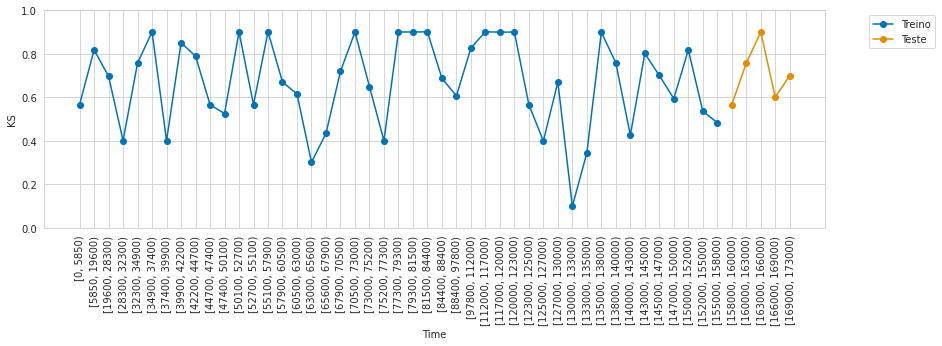

--------------------------------------------
Cluster 1


,Treino,Teste
AUC,0.168286,0.126904
KS,0.083912,0.030647
LiftV_10,0.128723,0.090909
LiftV_20,0.142553,0.090909
IG,0.354157,0.311969
Prob_Corte,0.007024,0.008756
Acurácia,0.003847,0.002844
Acurácia_Balanceada,0.353408,0.478327


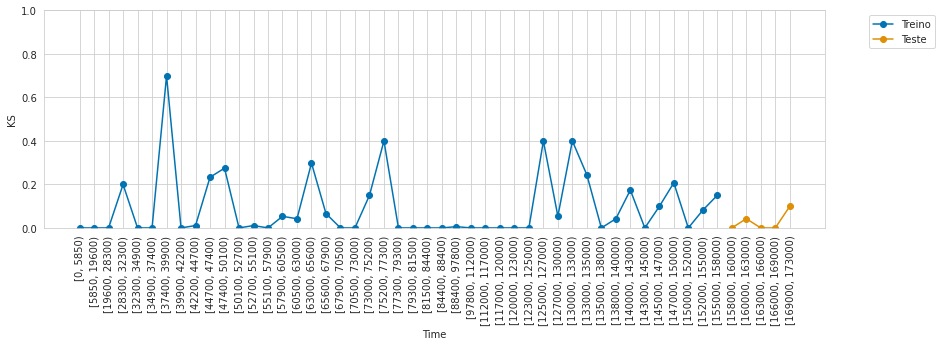

--------------------------------------------
Cluster 2


,Treino,Teste
AUC,0.145426,0.209202
KS,0.044562,0.095498
LiftV_10,0.019149,0.181818
LiftV_20,0.046809,0.181818
IG,0.214103,0.219095
Prob_Corte,0.033552,0.032031
Acurácia,0.102588,0.030863
Acurácia_Balanceada,0.119348,0.174411


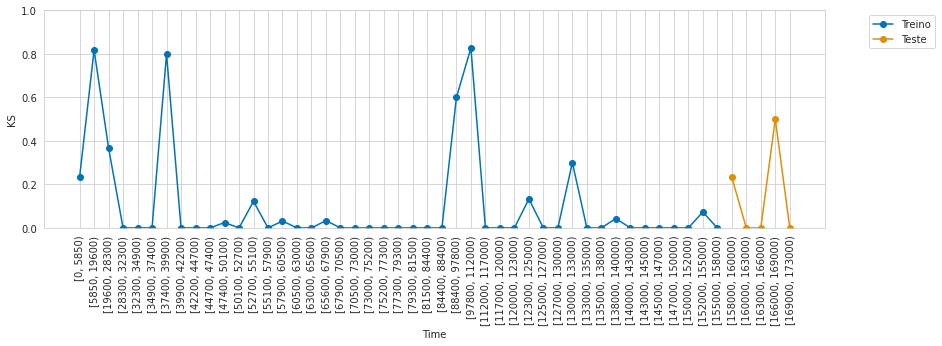

--------------------------------------------
Cluster 3


,Treino,Teste
AUC,0.802749,0.730814
KS,0.674635,0.651564
LiftV_10,0.627660,0.681818
LiftV_20,0.782979,0.681818
IG,0.173938,0.216006
Prob_Corte,0.574879,0.576255
Acurácia,0.895699,0.964784
Acurácia_Balanceada,0.835195,0.823410


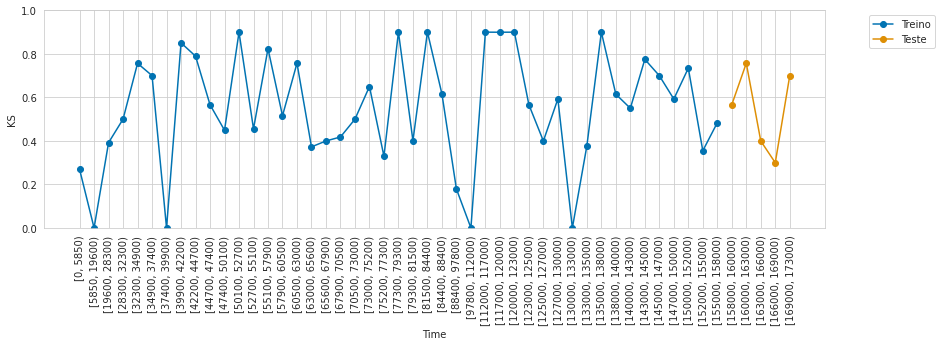

--------------------------------------------
Cluster 4


,Treino,Teste
AUC,0.154900,0.216291
KS,0.022466,0.052088
LiftV_10,0.027660,0.090909
LiftV_20,0.031915,0.181818
IG,0.195768,0.311665
Prob_Corte,0.039985,0.038619
Acurácia,0.080558,0.001650
Acurácia_Balanceada,0.159283,0.205213


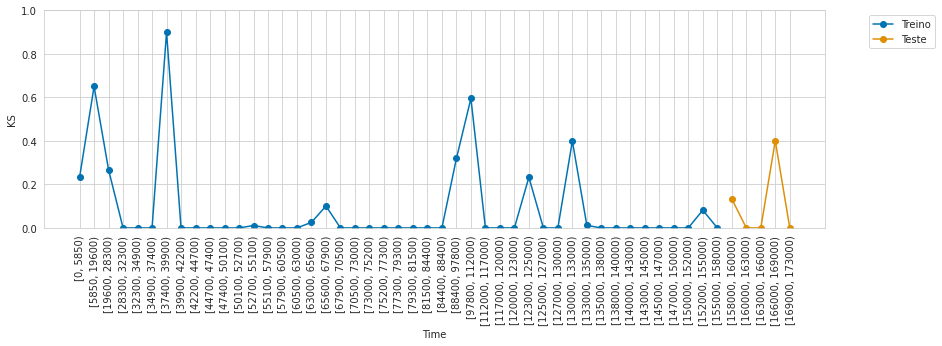

--------------------------------------------
Cluster 5


,Treino,Teste
AUC,0.158048,0.235436
KS,0.022997,0.130833
LiftV_10,0.044681,0.181818
LiftV_20,0.048936,0.181818
IG,0.194346,0.311969
Prob_Corte,0.033580,0.029602
Acurácia,0.081677,0.003652
Acurácia_Balanceada,0.148163,0.183505


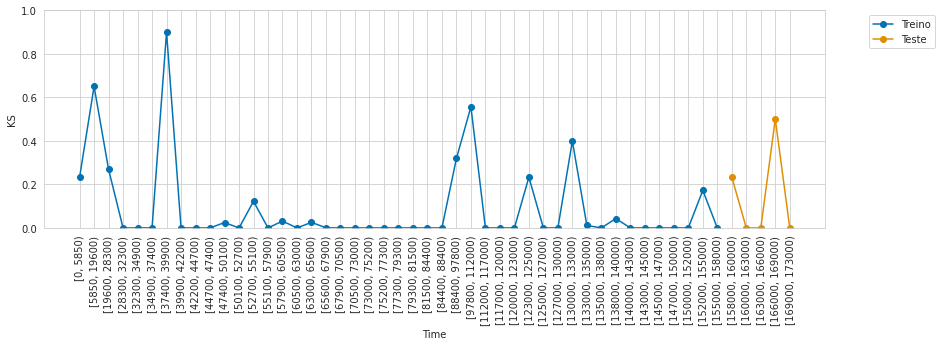

--------------------------------------------
Cluster 6


,Treino,Teste
AUC,0.146768,0.204718
KS,0.044132,0.031567
LiftV_10,0.010638,0.068182
LiftV_20,0.038298,0.181818
IG,0.203401,0.203074
Prob_Corte,0.029781,0.031075
Acurácia,0.112376,0.045539
Acurácia_Balanceada,0.126375,0.181755


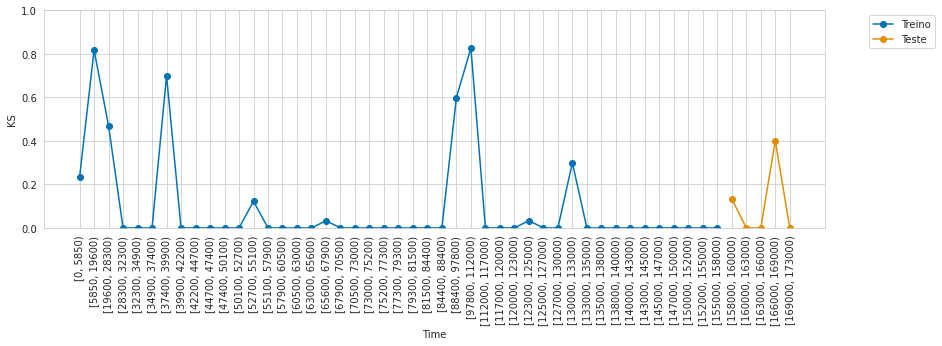

--------------------------------------------
Cluster 7


,Treino,Teste
AUC,0.148580,0.099384
KS,0.009783,0.000000
LiftV_10,0.018085,0.022727
LiftV_20,0.037234,0.090909
IG,0.192056,0.311969
Prob_Corte,0.021718,0.012866
Acurácia,0.091114,0.010498
Acurácia_Balanceada,0.150767,0.164221


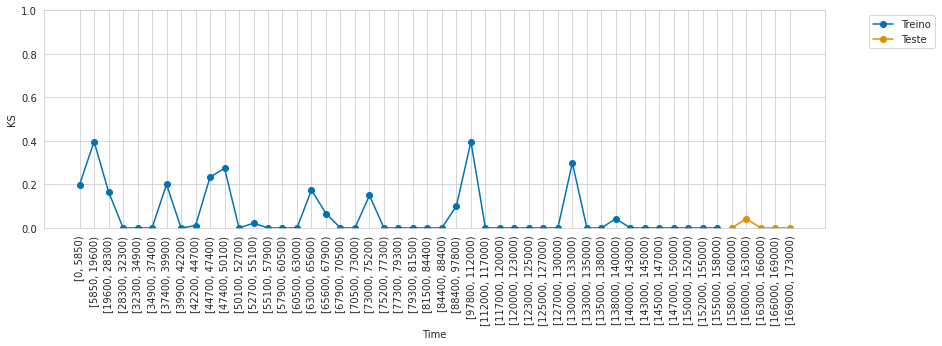

In [ ]:
for i in range(0, n_clusters):
    print('--------------------------------------------')
    print(f'Cluster {str(i)}')

    df_treino = df.loc[mask_treino, [coluna_temporal, alvo]].copy()
    df_treino['Prob'] = clusters_prob_treino[:, i]
    df_treino[alvo] = df_treino[alvo].str.replace("'", '').astype(int)

    df_teste = df.loc[mask_teste, [coluna_temporal, alvo]].copy()
    df_teste['Prob'] = clusters_prob_teste[:, i]
    df_teste[alvo] = df_teste[alvo].str.replace("'", '').astype(int)

    dict_dfs_clf = {'Treino': df_treino, 'Teste': df_teste}

    avalia = aml.AvaliaDatasetsClassificacao(dict_dfs_clf, alvo, 'Prob', num_div_prob = 100)
    display(avalia.valor_metricas().loc[['AUC', 'KS', 
                                    'LiftV_10', 'LiftV_20', 
                                    'IG', 'Prob_Corte', 
                                    'Acurácia', 'Acurácia_Balanceada']])

    avalia.calcula_metricas_condicionais(dict_dfs_clf, coluna_temporal, parametros_padrao=False, num_div_prob = 10, num_div = 50)
    avalia.grafico_metrica_condicional_geral(coluna_temporal, metrica = 'KS', ylim = [0, 1], rot = 90, figsize = (14, 4))

### Análise Anomalias - Alvo Oculto

In [ ]:
print('Treino')
df_aux = df.loc[mask_treino, [alvo]].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia
df_res = pd.DataFrame(df_aux.groupby('Anomalia').apply(lambda x: g(x)))
display(df_res)

print('Teste')
df_aux = df.loc[mask_teste, [alvo]].copy()
df_aux['Anomalia'] = grau_an_teste > corte_anomalia
df_res = pd.DataFrame(df_aux.groupby('Anomalia').apply(lambda x: g(x)))
display(df_res)

Treino


,,'0','1'
Anomalia,,,
False,,0.999086,0.000914
True,,0.907104,0.092896


Teste


,,'0','1'
Anomalia,,,
False,,0.999469,0.000531
True,,0.967890,0.032110


,Treino,Teste
AUC,0.933898,0.906127
KS,0.782217,0.767442
LiftV_10,0.861702,0.818182
LiftV_20,0.893617,0.863636
IG,0.286515,0.241216
Prob_Corte,1.337757,1.061519
Acurácia,0.966749,0.967838
Acurácia_Balanceada,0.869723,0.824939


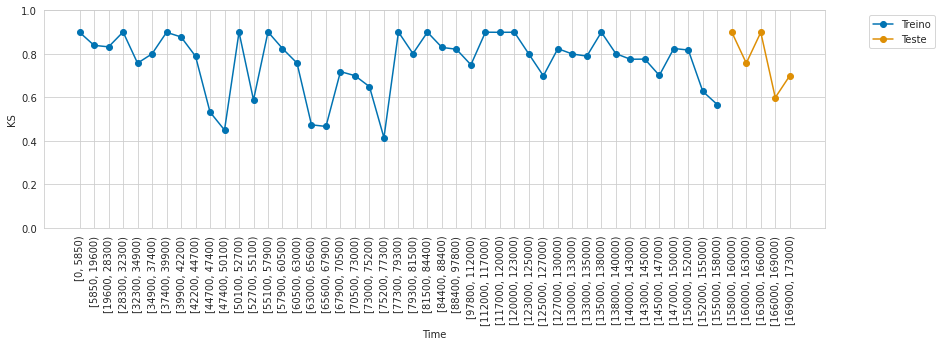

In [ ]:
df_treino = df.loc[mask_treino, [coluna_temporal, alvo]].copy()
df_treino['Grau_Anomalia'] = grau_an_treino
df_treino[alvo] = df_treino[alvo].str.replace("'", '').astype(int)

df_teste = df.loc[mask_teste, [coluna_temporal, alvo]].copy()
df_teste['Grau_Anomalia'] = grau_an_teste
df_teste[alvo] = df_teste[alvo].str.replace("'", '').astype(int)

dict_dfs_clf = {'Treino': df_treino, 'Teste': df_teste}

avalia = aml.AvaliaDatasetsClassificacao(dict_dfs_clf, alvo, 'Grau_Anomalia', num_div_prob = 100)
display(avalia.valor_metricas().loc[['AUC', 'KS', 
                                    'LiftV_10', 'LiftV_20', 
                                    'IG', 'Prob_Corte', 
                                    'Acurácia', 'Acurácia_Balanceada']])

avalia.calcula_metricas_condicionais(dict_dfs_clf, coluna_temporal, parametros_padrao=False, num_div_prob = 10, num_div = 50)
avalia.grafico_metrica_condicional_geral(coluna_temporal, metrica = 'KS', ylim = [0, 1], rot = 90, figsize = (14, 4))